In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
pd.set_option("display.max_colwidth",200)
pd.options.display.float_format = '{:,.2f}'.format

# Thành viên nhóm
| Họ và tên      | MSSV |
| ----------- | ----------- |
| Lê Anh Vũ| 19120724|
| Nguyễn Phú Thụ| 19120673|


# 1. Movies dataset

## 1. Mô tả dữ liệu: Dữ liệu mô tả các bộ phim nổi tiếng nhất từ 2003-2022
- <span style="font-size:18px;font-family: Times New Roman;">Tập dữ liệu mô tả các thông tin về bộ phim như: thể loại, đạo diện sản xuất, dàn diễn viên, thời gian khởi chiếu, v.v </span>
- <span style="font-size:18px;font-family: Times New Roman;">Tập dữ liệu cũng cho biết các thông tin về doanh thu như: số vốn đầu tư và doanh thu</span>
- <span style="font-size:18px;font-family: Times New Roman;">Ý nghĩa các trường thuộc tính trong dataset:</span>
    | Syntax      | Description |
    | ----------- | ----------- |
    | Title      | Tên phim       |
    | Rating   | điểm đánh giá phim dựa theo iMDB        |
    | Year      | Năm khởi chiếu       |
    | Month   | Tháng khởi chiếu        |
    | Certificate      | Chứng chỉ film       |
    | Runtime   | Thời lượng phim        |
    | Directors      | Đạo diễn       |
    | Stars   | Diễn viên trong film        |
    | Genre      | Thể loại       |
    | Filming_location   | Địa điểm phim quay hình        |
    | Country_of_origin   | Quốc gia tham gia sản xuất        |

**<span style="font-size:17px;">Dữ liệu được update lần cuối trên kaggle là 02/03/2023.</span>**

## 2. Bài toán
- <span style="font-size:18px;font-family: Times New Roman;">Tập dữ liệu có thể giúp xây dựng **recommendation system** để giới thiệu end-user các bộ phim đang hot hiện nay </span>
- <span style="font-size:18px;font-family: Times New Roman;">Từ đó giúp cải thiện doanh số cho các công ty kinh doanh về mảng chiếu phim.</span>

## 3. EDA

In [3]:
movie_df = pd.read_csv('movies.csv')
movie_df.head(2)

,Title,Rating,Year,Month,Certificate,Runtime,Directors,Stars,Genre,Filming_location,Budget,Income,Country_of_origin
0,Avatar: The Way of Water,8.00,2022,December,PG-13,192,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver, Stephen Lang","Action, Adventure, Fantasy",New Zealand,"$350,000,000","$681,081,686",United States
1,Guillermo del Toro's Pinocchio,7.80,2022,December,PG,117,"Guillermo del Toro, Mark Gustafson","Ewan McGregor, David Bradley, Gregory Mann, Burn Gorman","Animation, Drama, Family",USA,"$35,000,000","$71,614","United States, Mexico, France"


### 3.1 Dữ liệu có bao nhiêu dòng, cột

In [4]:
print(f'Dữ liệu có {movie_df.shape[0]} dòng')
print(f'Dữ liệu có {movie_df.shape[1]} cột')

Dữ liệu có 2000 dòng
Dữ liệu có 13 cột


### 3.2 Dữ liệu có thị trùng lặp hay không ?

In [5]:
movie_df.duplicated().sum()

0

### 3.3 Kiểu dữ liệu có gì bất thường ?

In [6]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              2000 non-null   object 
 1   Rating             1998 non-null   float64
 2   Year               2000 non-null   int64  
 3   Month              2000 non-null   object 
 4   Certificate        1966 non-null   object 
 5   Runtime            2000 non-null   object 
 6   Directors          2000 non-null   object 
 7   Stars              2000 non-null   object 
 8   Genre              2000 non-null   object 
 9   Filming_location   2000 non-null   object 
 10  Budget             2000 non-null   object 
 11  Income             2000 non-null   object 
 12  Country_of_origin  2000 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 203.2+ KB


<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Dữ liệu chưa giá trị Unknown tương đương NaN </span>
- <span style="font-size:17px;font-family: Times New Roman;">Dữ liệu numerical bao gồm các trường thuộc tính rating, year. Còn lại đa số là kiểu object hoặc categorical </span>
- <span style="font-size:17px;font-family: Times New Roman;">Một số trường thuộc tính như budget, income có sai khác về đơn vị đo lường. </span>

<span style="font-size:18px;font-family: Times New Roman;">**Tiền xử lý giá trị Unknown** </span> 

In [7]:
movie_df.replace('Unknown', np.nan, inplace=True)

<span style="font-size:18px;font-family: Times New Roman;">**Tiền xử lý trường thuộc tính Budget và Income** </span> 

In [8]:
# các giá trị tiền tệ
movie_df['Budget'].str[:1].value_counts()

$    1619
€      39
£      20
₩       4
C       3
₹       2
¥       2
A       2
S       1
D       1
N       1
Name: Budget, dtype: int64

In [9]:
# hệ quy đổi tiền tệ, chúng ta lấy $(USD) là chuẩn.
conversion_dict = {
    '$': 1.0,
    '€': 1.07,
    '£': 1.21,
    '₩': 0.00078,
    'C': 0.73,
    '₹': 0.012,
    '¥': 0.0075,
    'A': 0.68,
    'S': 0.095,
    'D': 0.14,
    'N': 0.10 
}

for idx in range(movie_df.shape[0]):
    if not pd.isnull(movie_df.loc[idx,'Budget']):
        movie_df.loc[idx,'Budget'] = int(re.sub("[^0-9]", "",movie_df.loc[idx,'Budget'])) * conversion_dict[movie_df.loc[idx,'Budget'][:1]]
    
    if not pd.isnull(movie_df.loc[idx,'Income']):
        movie_df.loc[idx,'Income'] = int(re.sub("[^0-9]", "",movie_df.loc[idx,'Income'])) * conversion_dict[movie_df.loc[idx,'Income'][:1]]
        
        
# chuyển đổi dữ liệu cột Budget và Income, Runtime vê float
movie_df['Budget'] = movie_df['Budget'].astype('float64')
movie_df['Income'] = movie_df['Income'].astype('float64')
movie_df['Runtime'] = movie_df['Runtime'].astype('float64')

### 3.4 Mỗi trường thuộc tính có giá trị thiếu không ?

In [10]:
movie_df.isna().sum()

Title                  0
Rating                 2
Year                   0
Month                  0
Certificate           34
Runtime                2
Directors              0
Stars                  0
Genre                  0
Filming_location      76
Budget               306
Income               146
Country_of_origin      0
dtype: int64

### 3.5 Thống kê dữ liệu numerical

In [11]:
def missing_ratio(column):
    return (column.isna().mean() * 100).round(2)

def lower_quantile(column):
    return column.quantile(q= 0.25)

def upper_quantile(column):
    return column.quantile(q= 0.75)


In [12]:
numerical_df = movie_df[['Rating', 'Runtime', 'Budget', 'Income']]
numerical_df.aggregate([missing_ratio, pd.Series.min, lower_quantile,
                          pd.Series.mean, upper_quantile, pd.Series.max])

,Rating,Runtime,Budget,Income
missing_ratio,0.10,0.10,15.30,7.30
min,1.90,50.00,10.00,305.00
lower_quantile,6.12,99.00,"17,000,000.00","24,560,593.25"
mean,6.67,113.22,"61,231,272.41","187,824,976.38"
upper_quantile,7.30,124.00,"85,000,000.00","220,564,894.00"
max,9.60,242.00,"356,000,000.00","2,922,917,914.00"


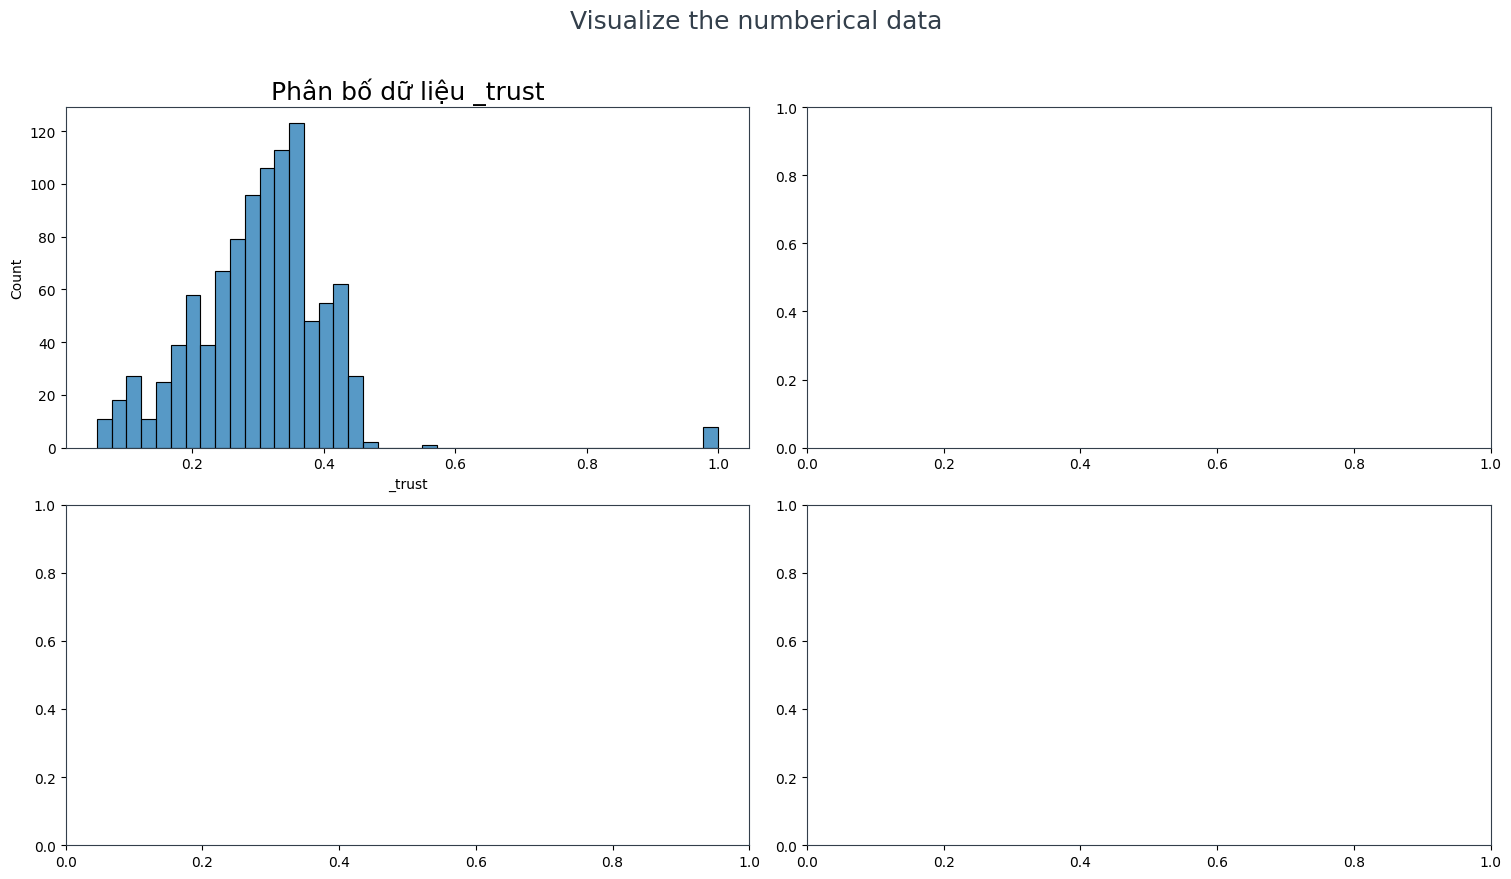

In [130]:
plt.rcParams['figure.figsize'] = 15,8
fig , axs = plt.subplots(2,2,constrained_layout = True)
idx = 0
while idx < numerical_df.shape[1]:
    r , c = idx // 2, idx % 2
    sns.histplot(x = numerical_df.iloc[:,idx], ax = axs[r,c])
    axs[r,c].set_title(f'Phân bố dữ liệu {numerical_df.columns[idx]}', fontsize = 18)
    idx += 1

plt.suptitle('Visualize the numberical data', fontsize=18, y=1.08, color = '#333F4B')
plt.show();

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Các trường thuộc tính **Rating và Runtime** gần với phân phối chuẩn. </span>
- <span style="font-size:17px;font-family: Times New Roman;">Các trường thuộc tính **Budget và Income** thì bị lệch phải khá nhiều. </span>

### 3.6 Thống kê dữ liệu categorical

In [14]:
movie_df[['Month', 'Certificate', 'Filming_location']].agg([missing_ratio,pd.Series.unique,pd.Series.nunique])

,Month,Certificate,Filming_location
missing_ratio,0.00,1.70,3.80
unique,"[December, August, November, January, October, March, September, May, April, July, June, February, 2014, 2008]","[PG-13, PG, R, TV-14, TV-MA, TV-PG, TV-Y7, Not Rated, nan, NC-17, TV-G, Unrated, G]","[New Zealand, USA, Japan, Ireland, nan, Canada, UK, Norway, Greece, Mexico, Spain, Italy, Bulgaria, Australia, Iceland, Belgium, Germany, Turkey, South Africa, France, South Korea, India, Egypt, A..."
nunique,14,12,96


<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Trường thuộc tính Month có các giá trị sai như 2014, 2008 $\rightarrow$ Xóa những dòng này</span>
- <span style="font-size:17px;font-family: Times New Roman;">Các trường thuộc tính **genre, directs, stars, country_of_origin** có thể là danh sách nhưng vẫn chưa được tiền xử lý </span>

In [15]:
movie_df = movie_df[(movie_df['Month'] != '2014')\
                    &(movie_df['Month'] != '2008')].reset_index().drop(columns = 'index')

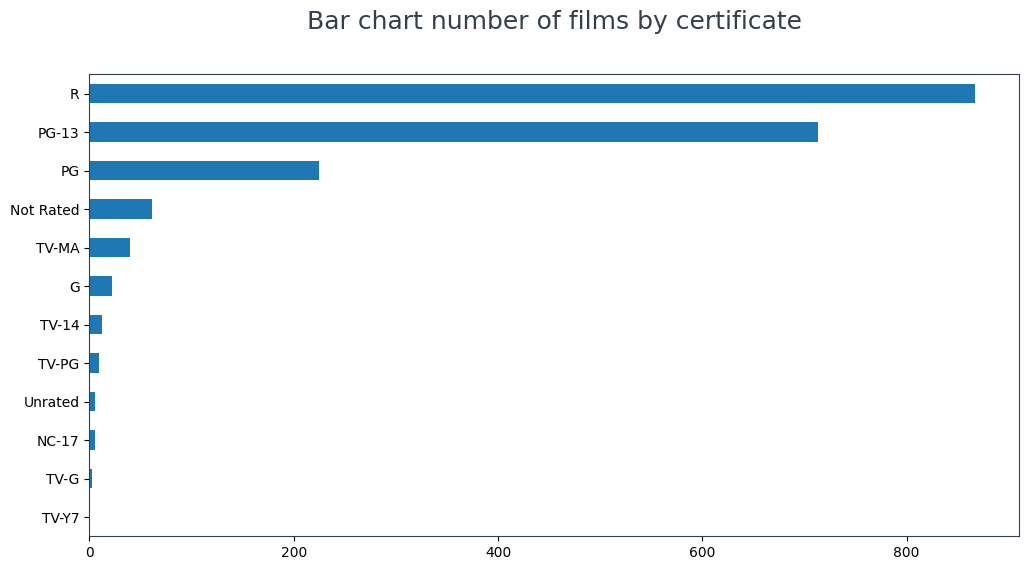

In [129]:
plt.rcParams['figure.figsize'] = 12,6
movie_df['Certificate'].value_counts(ascending=True).plot.barh()
plt.title('Bar chart number of films by certificate', fontsize=18, y=1.08, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Đa số các phim có chứng chỉ thuộc về R (trên 17 tuổi) và PG-13 (trên 13 tuổi) với số lượng áp đảo. Tiếp theo sau là PG và Not Rated. </span>

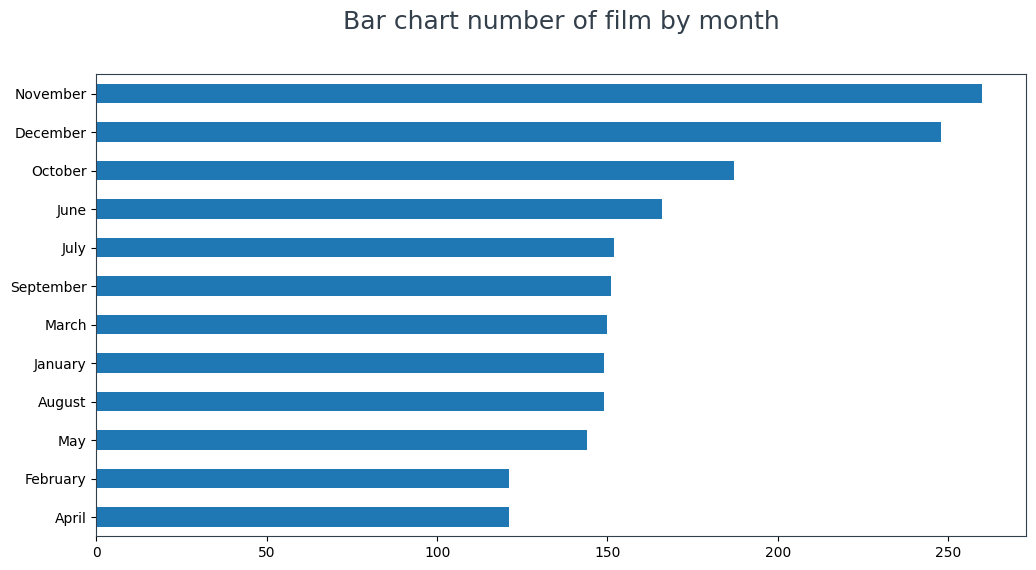

In [128]:
movie_df['Month'].value_counts(ascending=True).plot.barh()
plt.title('Bar chart number of film by month', fontsize=18, y=1.08, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Đa số các phim có phát hành vào khoảng thời gian cuối năm từ tháng 10 đến tháng 12. Các tháng còn lại thì chênh lệch không đáng kể với nhau </span>

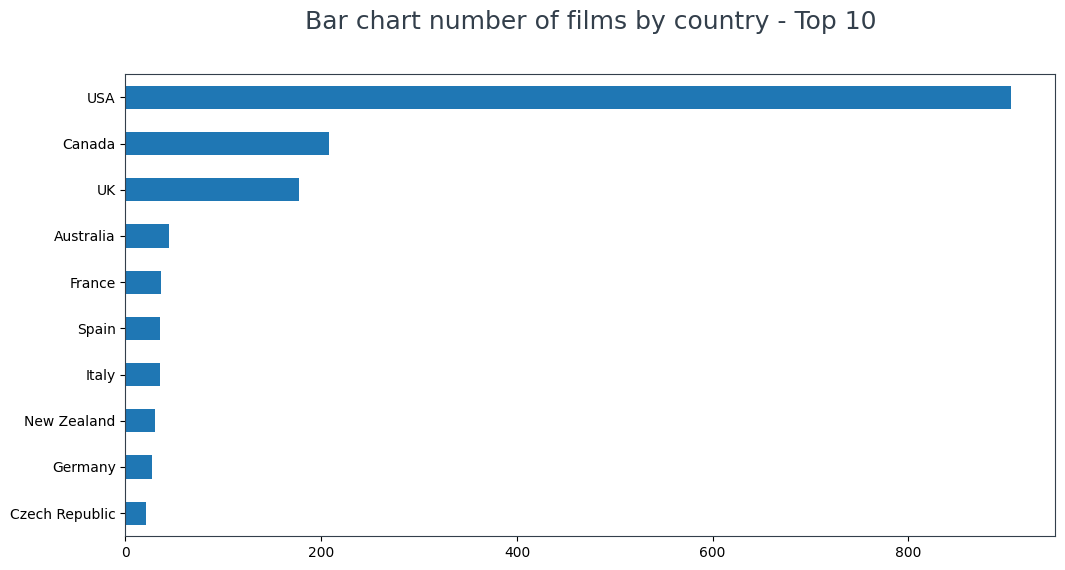

In [127]:
movie_df['Filming_location'].value_counts(ascending=True).tail(10).plot.barh()
plt.title('Bar chart number of films by country - Top 10', fontsize=18, y=1.08, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Đa số các phim phổ biến ở được quay hình ở USA với số lượng áp đảo. Tiếp theo sau là các nước Canada và UK cũng khá nhiều bộ phim nổi bật hơn so với các quốc gia còn lại.</span>

<span style="font-size:18px;font-family: Times New Roman;">**Tiền xử lý trường thuộc Genre, Directors, Stars, Country_of_origin** </span>  

In [19]:
movie_df['Genre'] = movie_df['Genre'].apply(lambda x: [i.strip() for i in x.split(',')])
movie_df['Directors'] = movie_df['Directors'].apply(lambda x: [i.strip() for i in x.split(',')])
movie_df['Stars'] = movie_df['Stars'].apply(lambda x: [i.strip() for i in x.split(',')])
movie_df['Country_of_origin'] = movie_df['Country_of_origin'].apply(lambda x: [i.strip() for i in x.split(',')])

<span style="font-size:18px;font-family: Times New Roman;">**Thống kê dữ liệu trường thuộc Genre, Directors, Stars, Country_of_origin** </span> 

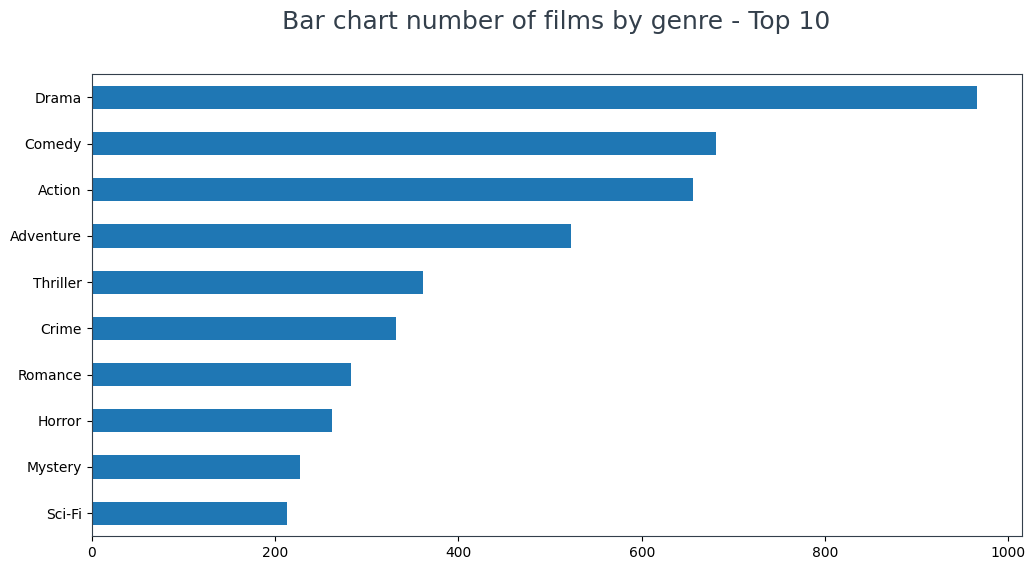

In [126]:
plt.rcParams['figure.figsize'] = 12,6
movie_df.explode('Genre')['Genre'].value_counts(ascending=True).tail(10).plot.barh()
plt.title('Bar chart number of films by genre - Top 10', fontsize=18, y=1.08, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Trong 10 thể loại phim thì phổ biến nhất là **Drama**, các thể loại phim như **Comedy, Action, Adventure** cũng chiếm số lượng lớn. </span>
- <span style="font-size:17px;font-family: Times New Roman;">Các thể loại còn lại trong danh sách cũng chiếm số lượng tương đối và không chênh lệch nhau đáng kể </span>

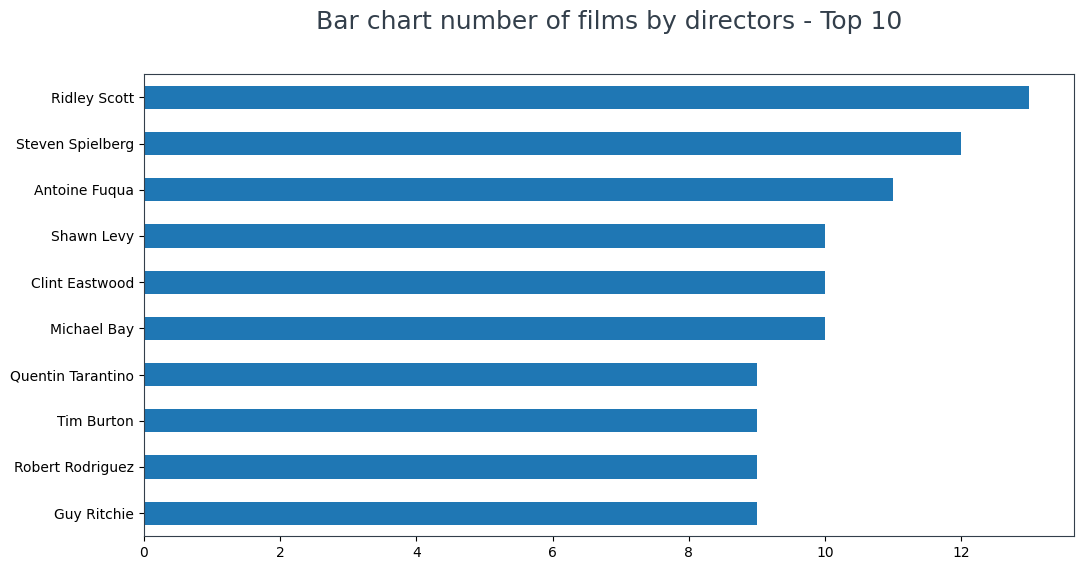

In [125]:
movie_df.explode('Directors')['Directors'].value_counts(ascending=True).tail(10).plot.barh()
plt.title('Bar chart number of films by directors - Top 10', fontsize=18, y=1.08, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Trong 10 đạo diễn có số lượng phim cao nhất thì nổi bật hơn là đạo diễn **Ridley Scott** </span>

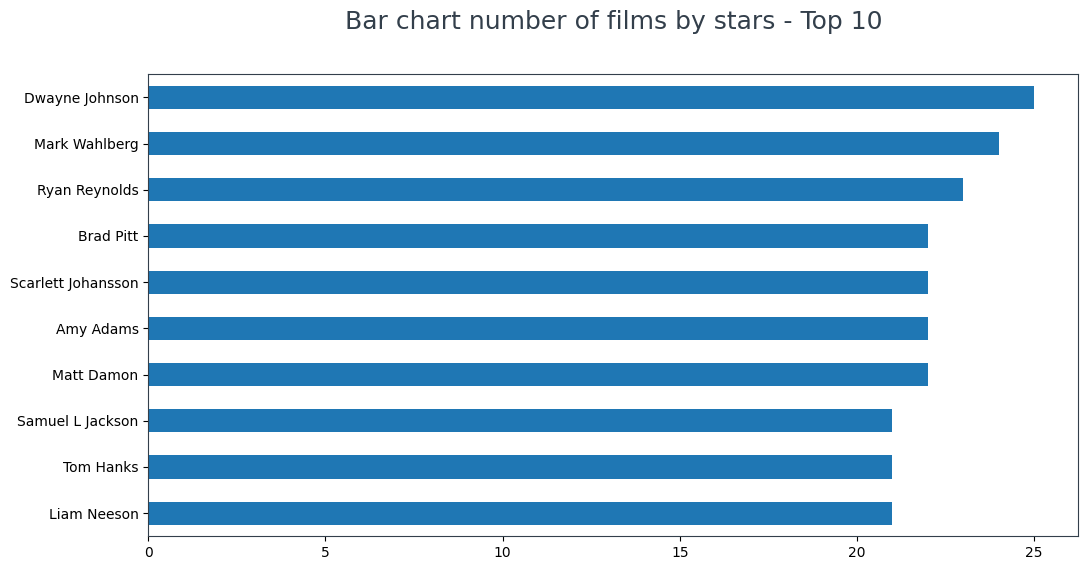

In [124]:
plt.rcParams['figure.figsize'] = 12,6
movie_df.explode('Stars')['Stars'].value_counts(ascending=True).tail(10).plot.barh()
plt.title('Bar chart number of films by stars - Top 10', fontsize=18, y=1.08, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Trong 10 diễn viên tham gia nhiều phim nhất thì nổi bật hơn là các diễn viên **Dwayne Johnson, Mark Wahlberg, Ryan Reynolds**.</span>
- <span style="font-size:17px;font-family: Times New Roman;">Các diễn viên còn lại trong danh sách có số lượng chênh lệch quá đáng kể so với các diễn viên trên.</span>

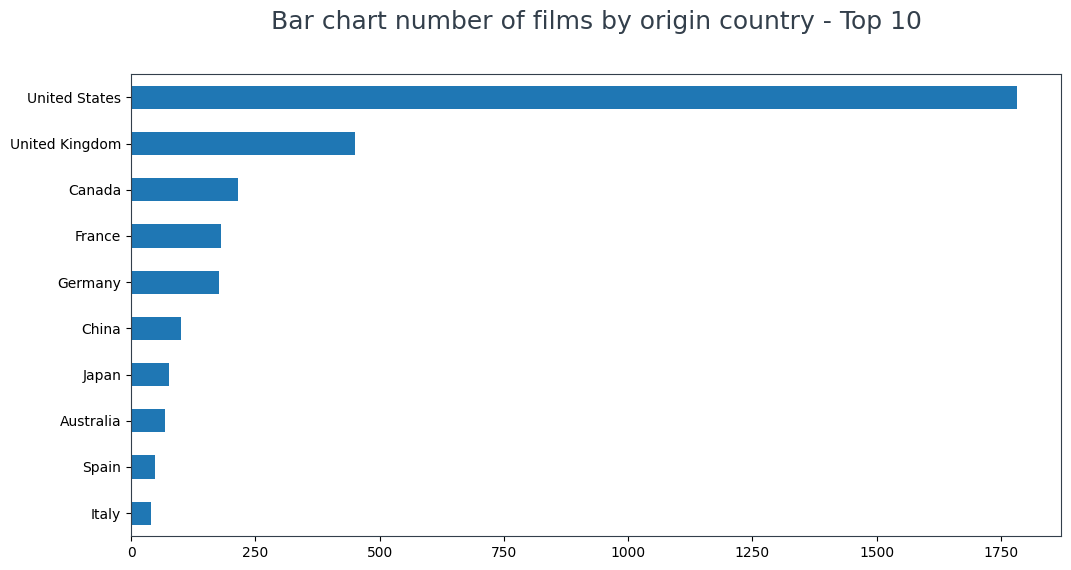

In [123]:
plt.rcParams['figure.figsize'] = 12,6
movie_df.explode('Country_of_origin')['Country_of_origin'].value_counts(ascending=True).tail(10).plot.barh()
plt.title('Bar chart number of films by origin country - Top 10', fontsize=18, y=1.08, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Trong 10 quốc gia tham gia sản xuất phim thì **USA** lại chiếm số lượng áp đảo. Tiếp theo vẫn là các quốc gia **Canada, UK, France, Germany**.</span>
- <span style="font-size:17px;font-family: Times New Roman;">Các quốc gia còn lại thì số lương chênh nhau không đáng kể nhưng khá thấp so với các quốc gia ở trên.</span>

### 3.7 Phân tích mối quan hệ giữa các biến

<span style="font-size:18px;font-family: Times New Roman;">**Mối quan hệ giữa Runtime, Budget và Income** </span> 

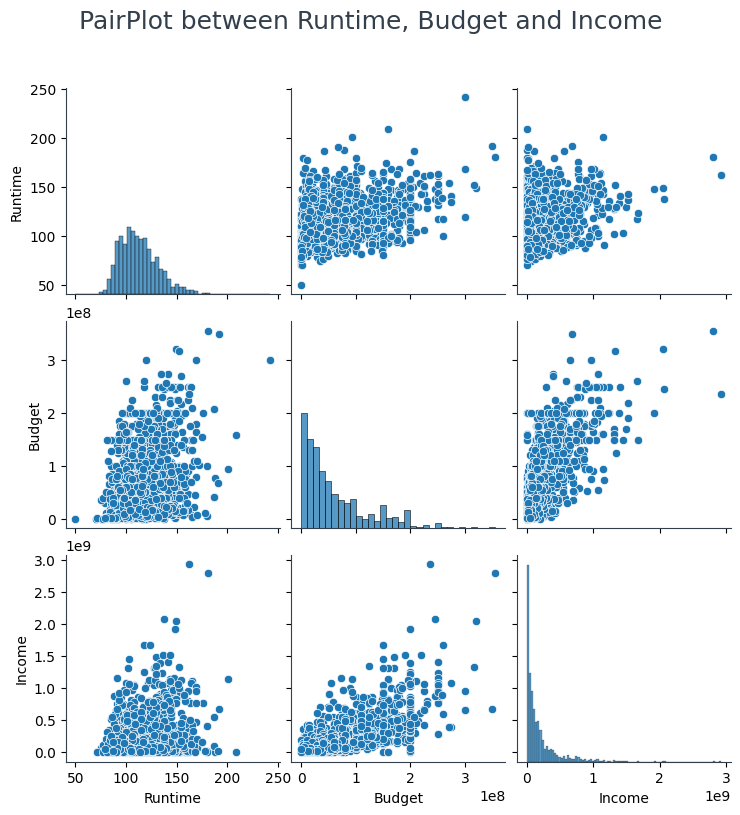

In [120]:
plt.rcParams['figure.figsize'] = 15,8
data = movie_df[['Runtime','Budget','Income']]
sns.pairplot(data)
plt.suptitle('PairPlot between Runtime, Budget and Income', fontsize=18, y=1.08, color = '#333F4B')
plt.show();

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Dựa vào pairplot thì thấy rõ giữa **Income** và **Budget** có quan hệ tuyến tính.</span>
- <span style="font-size:17px;font-family: Times New Roman;">Với **Runtime** thì có quan hệ tuyến tính với **Income** và **Budget** nhưng khá yếu và điểm giá trị nó tập trung tại một vùng chứ không tuyến tính như **Income** với **Budget**</span>

<span style="font-size:18px;font-family: Times New Roman;">**Mối quan hệ giữa Runtime, Bugdet với Rating** </span> 

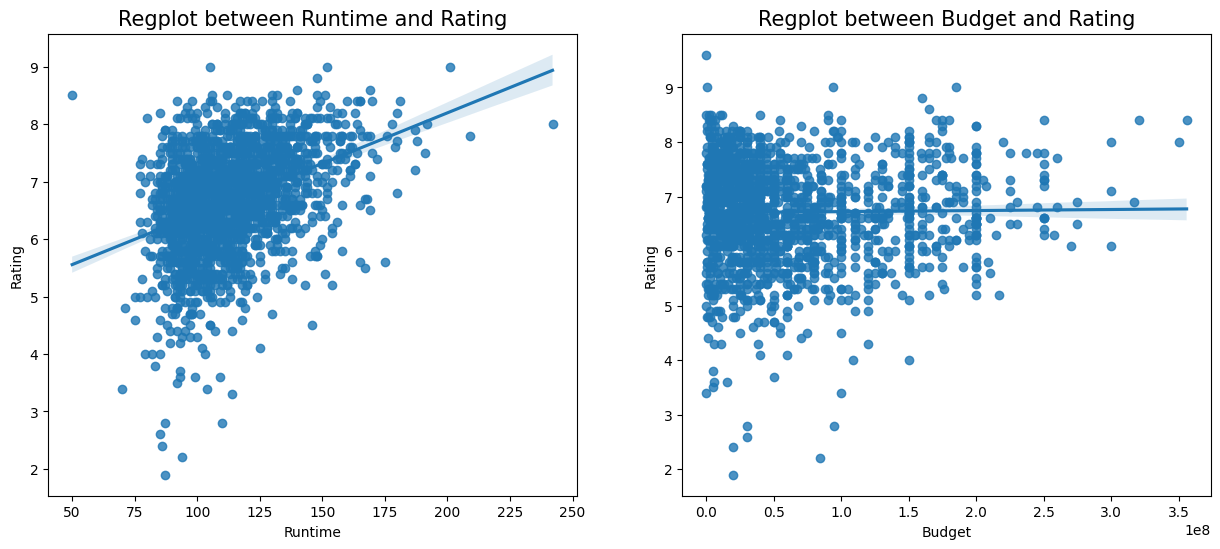

In [25]:
fig, axs = plt.subplots(1,2,figsize= (15,6))
sns.regplot(x = 'Runtime', y = 'Rating', data = movie_df, ax = axs[0]);
axs[0].set_title('Regplot between Runtime and Rating', fontsize = 15)

sns.regplot(x = 'Budget', y = 'Rating', data = movie_df, ax = axs[1]);
axs[1].set_title('Regplot between Budget and Rating', fontsize = 15)

plt.show();

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Dựa vào regplot thì thấy rõ quan hệ tuyế tính giữa **Runtime** và **Rating**.</span>
- <span style="font-size:17px;font-family: Times New Roman;">Giữa **Budget** và **Rating** thì ta thấy đường linear gần như đi ngang. Chứng tỏ 2 biến này gần như không có quan hệ tuyến tính và điểm giá trị tập trung.</span>

# 2. Github dataset

## 1. Mô tả dữ liệu: Dữ liệu bao gồm 2917951 github reponsitories 
- <span style="font-size:18px;font-family: Times New Roman;">Tập dữ liệu mô tả các thông tin như: tên reponsitory, số lượng stars, forks, issues, pull requests,v.v  </span>
- <span style="font-size:18px;font-family: Times New Roman;">Tập dữ liệu cũng cho biết các thông tin về người tham gia vào reponsitory và ngôn ngữ lập trình cho reponsitory đó.</span>
- <span style="font-size:18px;font-family: Times New Roman;">Ý nghĩa các trường thuộc tính trong dataset:</span>
    | Syntax      | Description |
    | ----------- | ----------- |
    | name      | Tên responsitory theo format: github_username/repository_name       |
    | stars_count   | số lượng star (tương đương like)        |
    | forks_count      | số lượng fork của reponsitory      |
    | watchers      | số người watcher reponsitory      |
    | pull_requests      | số lượng pull requests đang opened của reponsitory      |
    | primary_language   | ngôn ngữ chính được sử dụng trong dự án         |
    | languages_used      | các ngôn ngữ được sử dụng trong dự án      |
    | commit_count   | số lượng commit của reponsitpry         |
    | created_at      | thời gian tạo reponsitory       |
    | license   | giấy phép của reponsitory         |
    
- <span style="font-size:17px;">Dữ liệu này vào lúc nhóm em đăng ký thì chỉ chứa dataset gồm 1052 github reponsitory có ít nhất 1 issue open.</span> 
- <span style="font-size:17px;">**Nhưng hiện tại thì tác giả đã bổ sung thêm dataset chứa 2917951 github reponsitory**. Vì để cải thiện hiệu quả khám phá nên nhóm em sẽ khám phá dựa theo dataset mới.</span>

## 2. Bài toán
- <span style="font-size:18px;font-family: Times New Roman;">Tập dữ liệu có thể giúp xây dựng **recommendation system** để giới thiệu các reponsitory phù hợp với kiến thức và công nghệ của developer </span>

## 3. EDA

In [26]:
# Vì giới hạn size của github nên dataset này chỉ gồm 20.000 dòng có star_count cao nhất theo data gốc
github_df = pd.read_csv('repository_data.csv')

### 3.1 Dữ liệu có bao nhiêu dòng và cột

In [27]:
print(f'Dữ liệu có {github_df.shape[0]} dòng')
print(f'Dữ liệu có {github_df.shape[1]} cột')

Dữ liệu có 20000 dòng
Dữ liệu có 10 cột


### 3.2 Dữ liệu có bị trùng không

In [28]:
github_df.duplicated().sum()

31

- <span style="font-size:17px;font-family: Times New Roman;">**Dữ liệu có trùng lặp nên chúng ta sẽ xóa những dòng này.**</span>

### 3.3 Kiểu dữ liệu có gì bất thường không?

In [29]:
github_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              20000 non-null  object 
 1   stars_count       20000 non-null  int64  
 2   forks_count       20000 non-null  int64  
 3   watchers          20000 non-null  int64  
 4   pull_requests     20000 non-null  int64  
 5   primary_language  18335 non-null  object 
 6   languages_used    18325 non-null  object 
 7   commit_count      19999 non-null  float64
 8   created_at        20000 non-null  object 
 9   licence           16751 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 1.5+ MB


- <span style="font-size:18px;font-family: Times New Roman;">**Tiền xử lý trường thuộc tính created_at về datetime**</span>

In [30]:
def transform_datetime(col):
    col = col.str.replace('T', " ")
    col = col.str.replace('Z', "")
    col = pd.to_datetime(col, format = '%Y-%m-%d %H:%M:%S')
    return col

In [31]:
github_df['created_at'] = transform_datetime(github_df['created_at'])

### 3.4 Mỗi trường thuộc tính có bị thiếu không ?

In [32]:
github_df.isna().sum()

name                   0
stars_count            0
forks_count            0
watchers               0
pull_requests          0
primary_language    1665
languages_used      1675
commit_count           1
created_at             0
licence             3249
dtype: int64

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Chúng ta xây dựng **recommendation system** dựa vào progamming language để giới thiệu đến devloper nên việc thiếu 2 trường thuộc tính **primary_language** và **languages_used** sẽ giảm hiệu quả của hệ thống$\rightarrow$ Xóa những dòng thiếu 2 trường thuộc tính này. </span>

In [33]:
github_df = github_df[~(github_df['primary_language'].isna()\
                        | github_df['languages_used'].isna()\
                        | github_df['name'].isna())]

### 3.5 Thống kê dữ liệu numerical

In [34]:
numerical_github_df = github_df.select_dtypes('int64')

numerical_github_df.aggregate([missing_ratio, pd.Series.min, lower_quantile,
                               pd.Series.median, upper_quantile,
                               pd.Series.mean, pd.Series.max])

,stars_count,forks_count,watchers,pull_requests
missing_ratio,0.00,0.00,0.00,0.00
min,"1,038.00",0.00,0.00,0.00
lower_quantile,"1,228.00",177.00,39.00,24.00
median,"1,455.00",378.00,78.00,92.00
upper_quantile,"6,034.00",945.00,177.00,365.00
mean,"5,000.21",944.11,156.09,666.49
max,"359,805.00","132,246.00","8,448.00","182,176.00"


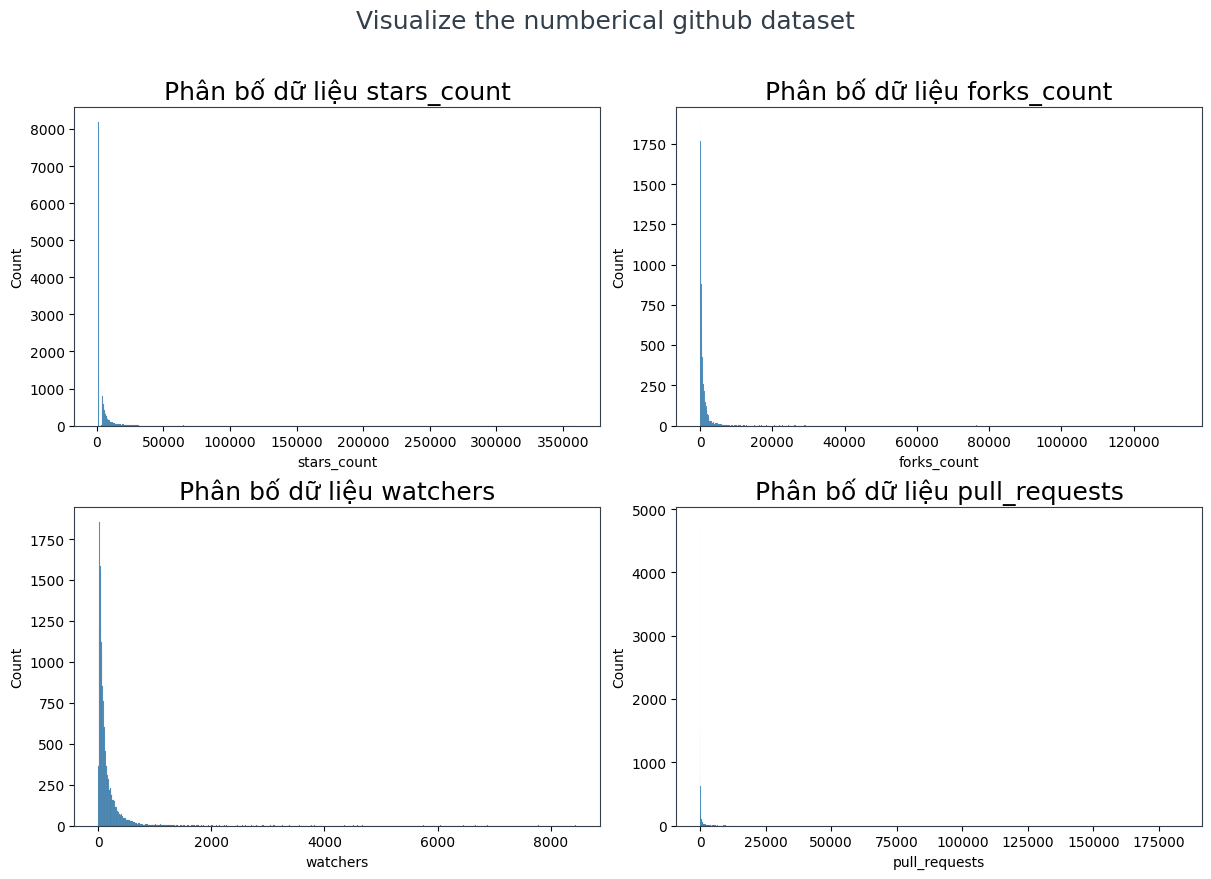

In [119]:
plt.rcParams['figure.figsize'] = 12,8
fig , axs = plt.subplots(2,2,constrained_layout = True)
idx = 0
while idx < numerical_github_df.shape[1]:
    r , c = idx // 2, idx % 2
    sns.histplot(x = numerical_github_df.iloc[:,idx], ax = axs[r,c])
    axs[r,c].set_title(f'Phân bố dữ liệu {numerical_github_df.columns[idx]}', fontsize = 18)
    idx += 1

plt.suptitle('Visualize the numberical github dataset', fontsize=18, y=1.08, color = '#333F4B')
plt.show();

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Các trường thuộc numerical tính đều lệch phải khá nhiều. </span>

### 3.6 Thống kê dữ liệu categorical

In [36]:
categorical_github_df = github_df.select_dtypes('O')
categorical_github_df.agg([missing_ratio,pd.Series.unique,pd.Series.nunique])

,name,primary_language,languages_used,licence
missing_ratio,0.00,0.00,0.00,12.80
unique,"[freeCodeCamp, developer-roadmap, public-apis, system-design-primer, vue, react, tensorflow, bootstrap, javascript-algorithms, ohmyzsh, awesome-python, Python, flutter, linux, vscode, javascript, ...","[TypeScript, Astro, Python, JavaScript, C++, Shell, Dart, C, Java, Markdown, Go, Rust, C#, Vue, CSS, PHP, Clojure, HTML, V, Haskell, Swift, Ruby, Vim Script, Roff, Kotlin, TeX, SCSS, Jupyter Noteb...","[['TypeScript', 'JavaScript', 'CSS', 'Shell', 'Dockerfile', 'EJS', 'HTML', 'Less'], ['Astro', 'JavaScript', 'TypeScript', 'CSS'], ['Python', 'Shell'], ['TypeScript', 'JavaScript', 'HTML', 'CSS', '...","[BSD 3-Clause ""New"" or ""Revised"" License, Other, MIT License, Apache License 2.0, nan, The Unlicense, Creative Commons Attribution 4.0 International, ISC License, Creative Commons Attribution Shar..."
nunique,17713,172,8941,35


<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Trường thuộc tính **languages_used** hiện đang có kiểu string $\rightarrow$ chuyển về array. </span>

In [37]:
def transform_array_string(col):
    col = col.apply(lambda x: re.findall("\w+", x))
    return col

In [38]:
github_df['languages_used'] = transform_array_string(github_df['languages_used'])

In [39]:
categorical_github_df = github_df.select_dtypes('O')

### 3.8 Phân tích mối quan hệ giữa các biến

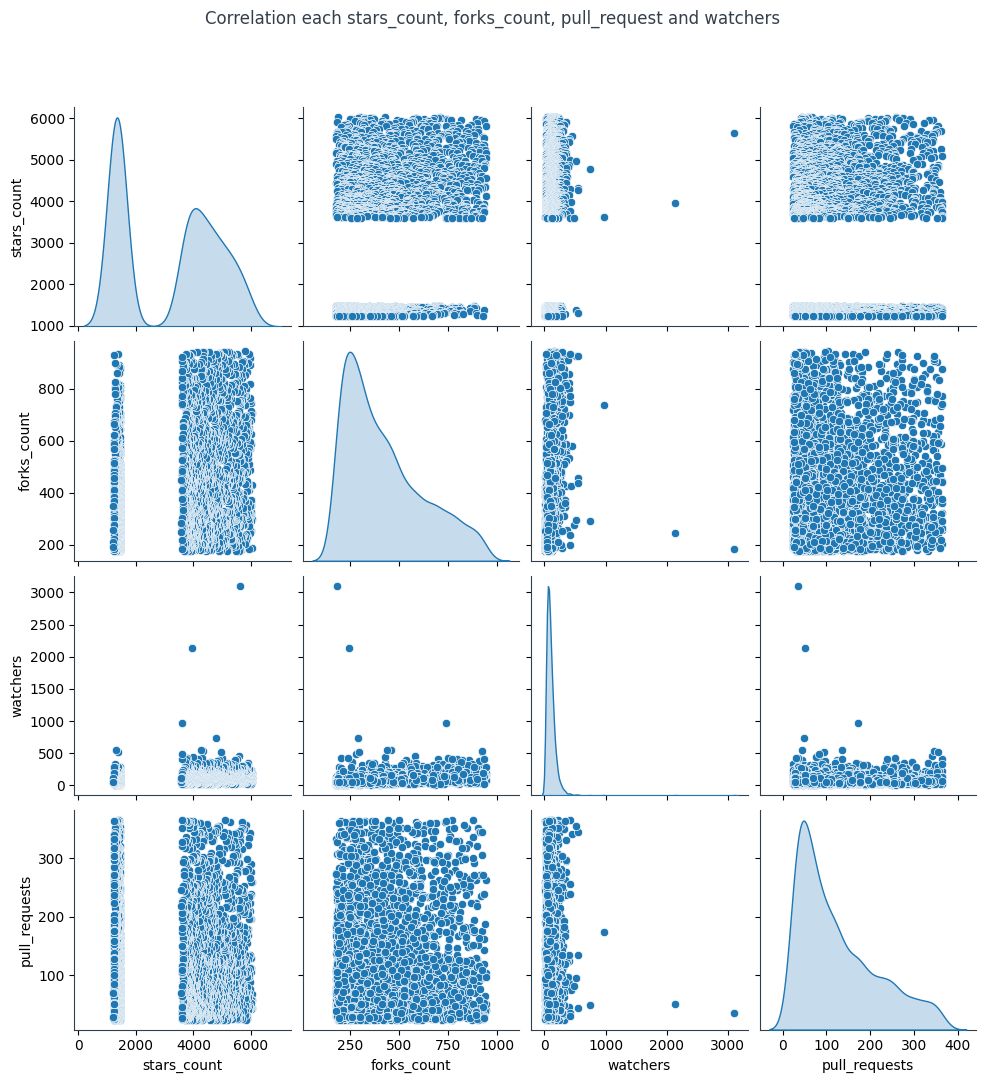

In [103]:
data = numerical_github_df[(github_df['stars_count'] >= github_df['stars_count'].quantile(.25))\
                      & (github_df['stars_count'] <= github_df['stars_count'].quantile(0.75))
                      & (github_df['forks_count'] >= github_df['forks_count'].quantile(.25))\
                        & (github_df['forks_count'] <= github_df['forks_count'].quantile(0.75))\
                        & (github_df['pull_requests'] >= github_df['pull_requests'].quantile(.25))\
                        & (github_df['pull_requests'] <= github_df['pull_requests'].quantile(0.75))]
g = sns.pairplot(data, diag_kind = 'kde')
g.fig.suptitle('Correlation each stars_count, forks_count, pull_request and watchers', y=1.08, color = '#333F4B')
plt.show();

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;"> Có dấu hiệu bất thường khi mà số lượng stars_count từ 2000 - 4000 không có một dữ liệu nào, có vẻ đây là sai số từ giai đoạn data processing</span>
- <span  style="font-size:17px;font-family: Times New Roman;"> Dường như không có mối tương quan giữa các thuộc tính trên, lượng phân bố dàn trải cho toàn bộ vùng dữ liệu. </span> 

In [72]:
github_df.nlargest(n=30, columns='stars_count')['p[r]']

,name,stars_count,forks_count,watchers,pull_requests,primary_language,languages_used,commit_count,created_at,licence
0,freeCodeCamp,359805,30814,8448,31867,TypeScript,"[TypeScript, JavaScript, CSS, Shell, Dockerfile, EJS, HTML, Less]","32,231.00",2014-12-24 17:49:19,"BSD 3-Clause ""New"" or ""Revised"" License"
5,developer-roadmap,225982,32534,6885,2082,Astro,"[Astro, JavaScript, TypeScript, CSS]","2,821.00",2017-03-15 13:45:52,Other
6,public-apis,225267,25654,3772,2897,Python,"[Python, Shell]","4,527.00",2016-03-20 23:49:42,MIT License
7,system-design-primer,208977,37414,6466,455,Python,"[Python, Shell]",328.00,2017-02-26 16:15:28,Other
8,vue,201896,33255,6051,2365,TypeScript,"[TypeScript, JavaScript, HTML, CSS, Shell]","3,545.00",2013-07-29 03:24:51,MIT License
9,react,200838,41721,6644,13061,JavaScript,"[JavaScript, HTML, CSS, C, TypeScript, CoffeeScript, C, Shell, Python, Makefile]","15,461.00",2013-05-24 16:15:54,MIT License
11,tensorflow,170578,87667,7788,22466,C++,"[C, Python, MLIR, Starlark, HTML, Go, C, Java, Jupyter, Notebook, Shell]","141,966.00",2015-11-07 01:19:20,Apache License 2.0
13,bootstrap,161399,77750,6845,14246,JavaScript,"[JavaScript, HTML, SCSS, CSS, PowerShell]","22,197.00",2011-07-29 21:19:00,MIT License
15,javascript-algorithms,159248,26396,4352,635,JavaScript,"[JavaScript, Shell]","1,076.00",2018-03-24 07:47:04,MIT License
16,ohmyzsh,154480,24897,2660,6726,Shell,"[Shell, Python, Makefile]","6,776.00",2009-08-28 18:15:37,MIT License


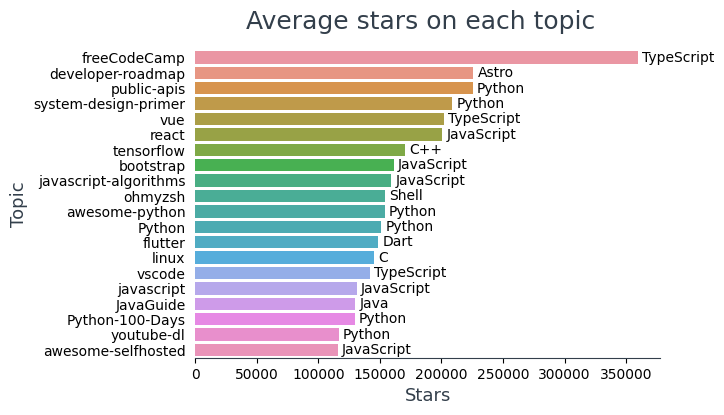

In [87]:
fig, ax = plt.subplots(figsize=(6,4), dpi=100)

plt.rcParams['axes.edgecolor']='#333F4B'

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='both', labelsize=10, bottom=True, left=False)

ax.grid(False)
ax.set_facecolor('white')

g = sns.barplot(data=github_df.nlargest(n=20, columns='stars_count'), x='stars_count', y='name');
g.bar_label(ax.containers[0], github_df.nlargest(n=20, columns='stars_count')['primary_language'], padding=3)
ax.set_xlabel('Stars', fontsize=13, color = '#333F4B')
ax.set_ylabel('Topic', fontsize=13, color = '#333F4B')
fig.suptitle('Most stars on each topic',fontsize=18, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;"> freeCodeCamp là topic hot nhất trên github khi mà số lượng đánh giá của nó gần gấp đôi topic thứ 2, có lẽ đây là một nền tảng học trực tuyến liên quan đến lập trình nổi tiếng nên topic này được thu hút hơn.</span>
- <span  style="font-size:17px;font-family: Times New Roman;">Python và javaScript đóng góp nhiều nhất trong số các topic được yêu thích. Bên cạnh đó, các ngôn ngữ ít phổ thông hơn như TypeScript hay Astro lại là ngôn ngữ chính cho các topic top đầu.</span> 

# The Colors of The Iconic Dress

## 1. Mô tả dữ liệu: Dữ liệu mô tả

- <span style="font-size:18px;font-family: Times New Roman;">Năm 2015, có một sự kiện thú vị trên nền tảng twitter. Mọi người tranh cãi màu sắc của một bức ảnh về chiếc váy, nhiều người thấy nó màu đen và xanh, những người khác lại thấy nó có màu trắng và vàng. Nhưng thực tế, chiếc váy có màu đen và xanh lam, điều này đã thu hút sự chú ý của các nhà khoa học để hiểu tại sao mọi người lại nhìn thấy nó với màu sắc khác nhau.</span>
- <span style="font-size:18px;font-family: Times New Roman;">Dataset bao gồm các nhận xét màu của bộ váy của những người từ các quốc gia khác nhau.</span>
- <span style="font-size:18px;font-family: Times New Roman;"> Ý nghĩa các trường thuộc tính trong dataset:</span>
    |Trường thuộc tính| Ý nghĩa|
    |:---|:---|
    |**_unit_id**| ID của bình luận|
    |**_created_at**| Thời gian người dùng đăng bình luận|
    |**_id**| Một ID khác|
    |**_started_at**| Thời gian bắt đầu thu thập dữ liệu|
    |**_tainted**| Có bị gây nhiễu hay không|
    |**_channel**| Kênh thu thập dữ liệu|
    |**_trust**| Độ tin cậy của người dùng|
    |**_worker_id**| ID của người dùng|
    |**_country**| Quốc gia của người dùng|
    |**_region**| Vùng của người dùng|
    |**_city**| Thành phố của người dùng|
    |**_ip**| Địa chỉ IP của người dùng|
    |**_color1**| Màu sắc thứ nhất của bộ váy|
    |**_color2**| Màu sắc thứ hai của bộ váy|
    |**_you**| Màu sắc mà người dùng nhìn thấy|
    |**_proccesed_color_combo**| Màu sắc thực tế của bộ váy|
    |**what group**| Nhóm mà người dùng thuộc về|

- <span style="font-size:18px;font-family: Times New Roman;">Dataset được thu thập từ trang web [Kaggle](https://www.kaggle.com/datasets/peacehegemony/the-colors-of-the-iconic-dress)</span>
- <span style="font-size:18px;font-family: Times New Roman;">Dataset được lưu trong file **Hashtag-That-Dress-DFE.csv**</span>

## 2. Bài toán
- <span style="font-size:18px;font-family: Times New Roman;">Tập dữ liệu này được dùng để khám phá sự thú vị về khoa học màu sắc.</span>
- <span style="font-size:18px;font-family: Times New Roman;">Bài toán: Dự đoán màu sắc thực tế của bộ váy dựa trên màu sắc mà người dùng nhìn thấy.</span>

## 3. EDA (Exploratory Data Analysis)
- <span style="font-size:18px;font-family: Times New Roman;">Đầu tiên, ta sẽ xem qua dữ liệu để hiểu được dữ liệu như thế nào.</span>
- <span style="font-size:18px;font-family: Times New Roman;">Sau đó, ta sẽ xem xét các trường thuộc tính của dữ liệu để hiểu được dữ liệu như thế nào.</span>
- <span style="font-size:18px;font-family: Times New Roman;">Cuối cùng, ta sẽ xem xét các giá trị bị thiếu của dữ liệu để xử lý dữ liệu.</span>

In [42]:
color_df = pd.read_csv('./Hashtag-That-Dress-DFE.csv', encoding='latin1')
color_df.head(5)

,_unit_id,_created_at,_id,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,_city,_ip,color1,color2,you,processed_color_combo,what group?
0,683415253,2/27/15 20:01,1578428229,2/27/15 20:00,False,clixsense,0.33,11477493,IND,2,Hyderabad,182.18.177.222,cyan,brown,I am a Night Owl. I prefer to be awake late at night.,brown & cyan,NaN
1,683415253,2/27/15 20:01,1578428232,2/27/15 20:00,False,neodev,0.56,31353544,VEN,NaN,NaN,190.201.116.194,white,gold,Both of the previous options apply well to who I am,white & gold,white group
2,683415253,2/27/15 20:01,1578428236,2/27/15 20:00,False,clixsense,0.28,29592447,BIH,1,Sarajevo,185.13.242.127,white,gold,Neither of the previous options apply well to who I am,white & gold,white group
3,683415253,2/27/15 20:01,1578428308,2/27/15 20:00,False,getpaid,0.33,30656104,MAR,49,Rabat,41.248.168.7,blue,black,I am a Night Owl. I prefer to be awake late at night.,black & blue,blue group
4,683415253,2/27/15 20:01,1578428352,2/27/15 20:00,False,neodev,0.44,31422367,SRB,0,Belgrade,93.86.138.220,black,blue,I am a Night Owl. I prefer to be awake late at night.,black & blue,blue group


### 3.1. Xem qua dữ liệu

In [43]:
print('Số lượng dòng dữ liệu: ', color_df.shape[0])
print('Số lượng cột dữ liệu: ', color_df.shape[1])

Số lượng dòng dữ liệu:  1015
Số lượng cột dữ liệu:  17


### 3.2. Dữ liệu có bị trùng không?

In [44]:
print('Số lượng dòng dữ liệu trùng: ', color_df.duplicated().sum())

Số lượng dòng dữ liệu trùng:  0


### 3.3. Xem xét các trường thuộc tính của dữ liệu

In [45]:
color_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               1015 non-null   int64  
 1   _created_at            1015 non-null   object 
 2   _id                    1015 non-null   int64  
 3   _started_at            1015 non-null   object 
 4   _tainted               1015 non-null   bool   
 5   _channel               1015 non-null   object 
 6   _trust                 1015 non-null   float64
 7   _worker_id             1015 non-null   int64  
 8   _country               1014 non-null   object 
 9   _region                855 non-null    object 
 10  _city                  851 non-null    object 
 11  _ip                    1015 non-null   object 
 12  color1                 1015 non-null   object 
 13  color2                 1015 non-null   object 
 14  you                    1015 non-null   object 
 15  proc

In [46]:
color_df['_tainted'].unique()

array([False])

### 3.4. Tiền xử lí cột `_tainted` và các cột datetime `_created_at` và `_started_at`

In [47]:
# xóa cột `_tainted` vì cột này không có ý nghĩa
color_df.drop('_tainted', axis=1, inplace=True)

In [48]:
# chuyển đổi cột `created_at` và `started_at` thành datetime
color_df['_created_at'] = pd.to_datetime(color_df['_created_at'])
color_df['_started_at'] = pd.to_datetime(color_df['_started_at'])

In [49]:
# xem xét lại các trường thuộc tính của dữ liệu `_created_at` và `_started_at`
color_df[['_created_at', '_started_at']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   _created_at  1015 non-null   datetime64[ns]
 1   _started_at  1015 non-null   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 16.0 KB


### 3.5. Xem xét các giá trị bị thiếu của dữ liệu

In [50]:
color_df.isna().sum()

_unit_id                   0
_created_at                0
_id                        0
_started_at                0
_channel                   0
_trust                     0
_worker_id                 0
_country                   1
_region                  160
_city                    164
_ip                        0
color1                     0
color2                     0
you                        0
processed_color_combo      0
what group?               89
dtype: int64

### 3.6. Thống kê dữ liệu numerical

In [51]:
numerical_df = color_df[['_trust']]
numerical_df.aggregate([missing_ratio, pd.Series.min, lower_quantile,
                          pd.Series.mean, upper_quantile, pd.Series.max])


,_trust
missing_ratio,0.00
min,0.06
lower_quantile,0.24
mean,0.30
upper_quantile,0.36
max,1.00


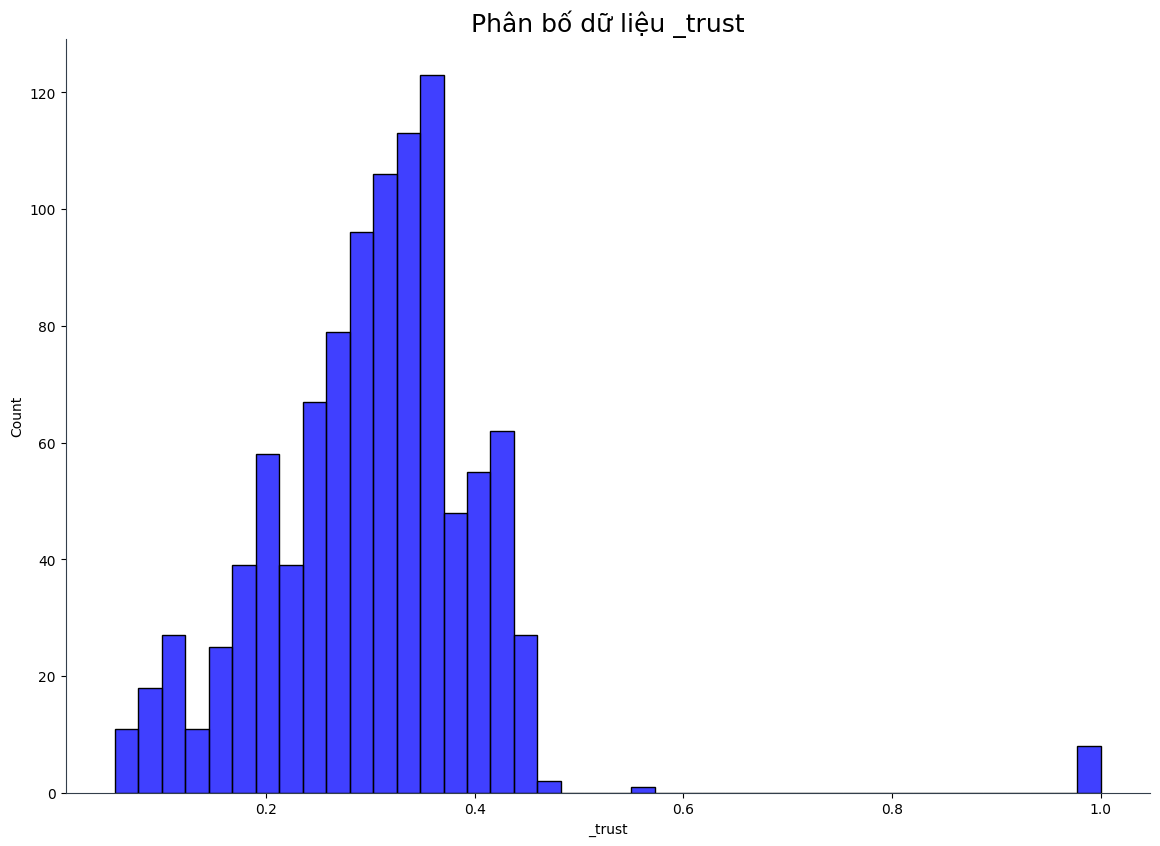

In [91]:
# historical for col _trust
plt.rcParams['figure.figsize'] = (40, 5)
sns.displot(color_df['_trust'], color='blue', height=8.27, aspect=11.7/8.27)
plt.title('Phân bố dữ liệu _trust', fontsize=18)
plt.show();

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;"> Phân bố của thuộc tính này khá chuẩn, xoay quanh điểm 0.3.</span>
- <span  style="font-size:17px;font-family: Times New Roman;">Có một số trường hợp outlier khi giá trị của trust là 1.0 (tuyệt đối).</span> 

### 3.7 Thống kê dữ liệu categorical

In [53]:
color_df[['_channel', '_country', '_region', '_city', 'color1', 'color2', 'you', 'processed_color_combo', 'what group?']].agg([missing_ratio, pd.Series.nunique, pd.Series.unique])

,_channel,_country,_region,_city,color1,color2,you,processed_color_combo,what group?
missing_ratio,0.00,0.10,15.76,16.16,0.00,0.00,0.00,0.00,8.77
nunique,21,82,134,510,13,13,4,41,2
unique,"[clixsense, neodev, getpaid, gifthunterclub, elite, tremorgames, superrewards, prodege, gptking, bitcoinget, instagc, eup_slw, inboxpounds, zoombucks, crowdguru, prizerebel, prizeplank, coinworker...","[IND, VEN, BIH, MAR, SRB, ROU, BRA, ESP, ALB, HRV, RUS, BGR, PAK, CYP, MKD, GRC, HUN, TUR, PRT, SAU, COL, EST, ARG, MDA, DEU, MEX, CAN, ARE, CHL, TUN, ITA, OMN, VNM, IDN, SVN, SVK, IRL, JAM, AUT, ...","[2, nan, 1, 49, 0, 14, 60, 51, 42, 3, 28, 4, E3, 35, 8, 34, 48, 45, 9, 16, 10, 22, 58, 11, 36, 25, 57, 7, 15, QC, 12, 6, 44, 68, 39, J2, 69, 56, 17, 41, 13, 19, H9, 61, BC, 5, A9, 21, 27, D9, 38, ...","[Hyderabad, nan, Sarajevo, Rabat, Belgrade, Visoko, Lukavac, Constanta, CastellÌ_n, VlorÌÇ, Sofia, Peshawar, Kolkata, Nicosia, Prilep, Athens, DunaÌ¼jvÌÁros, Beograd, Istanbul, Moscow, Manisa, Lag...","[cyan, white, blue, black, gold, gray, violet, yellow, brown, copper, green, pink, red]","[brown, gold, black, blue, green, white, yellow, gray, copper, cyan, orange, violet, pink]","[I am a Night Owl. I prefer to be awake late at night., Both of the previous options apply well to who I am, Neither of the previous options apply well to who I am, I am a Morning Person. I prefer...","[brown & cyan, white & gold, black & blue, blue & green, gold & gray, green & white, black & violet, blue & yellow, blue & gray, blue & copper, cyan & gray, brown & gray, blue & gold, green & viol...","[nan, white group, blue group]"


Xem xét từng giá trị ở cột `you`

In [54]:
color_df['you'].unique()

array(['I am a Night Owl. I prefer to be awake late at night.',
       'Both of the previous options apply well to who I am',
       'Neither of the previous options apply well to who I am',
       'I am a Morning Person. I prefer to be awake early in the morning'],
      dtype=object)

<span style="font-size:18px;font-family: Times New Roman;">Có thể tóm gọn các giá trị `you` có ý nghĩa như sau:</span>
- <span style="font-size:17px;font-family: Times New Roman;">`I am a Night Owl. I prefer to be awake late at night.`: `Night Owl`</span>
- <span style="font-size:17px;font-family: Times New Roman;">`I am a Morning Person. I prefer to be awake early in the morning.`: `Morning Person`</span>
- <span style="font-size:17px;font-family: Times New Roman;">`Both of the previous options apply well to who I am`: `Both`</span>
- <span style="font-size:17px;font-family: Times New Roman;">`Neither of the previous options apply well to who I am`: `Neither`</span>


In [55]:
# thay thế các giá trị có ý nghĩa bằng các giá trị mới
color_df['you'] = color_df['you'].replace(['I am a Night Owl. I prefer to be awake late at night.',
                                           'I am a Morning Person. I prefer to be awake early in the morning',
                                           'Both of the previous options apply well to who I am',
                                           'Neither of the previous options apply well to who I am'],
                                          ['Night Owl', 'Morning Person', 'Both', 'Neither'])
color_df['you'].unique()

array(['Night Owl', 'Both', 'Neither', 'Morning Person'], dtype=object)

<span style="font-size:17px;font-family: Times New Roman;">Chúng ta xem phân bố dữ liệu `color1` và `color2` như thế nào?</span>

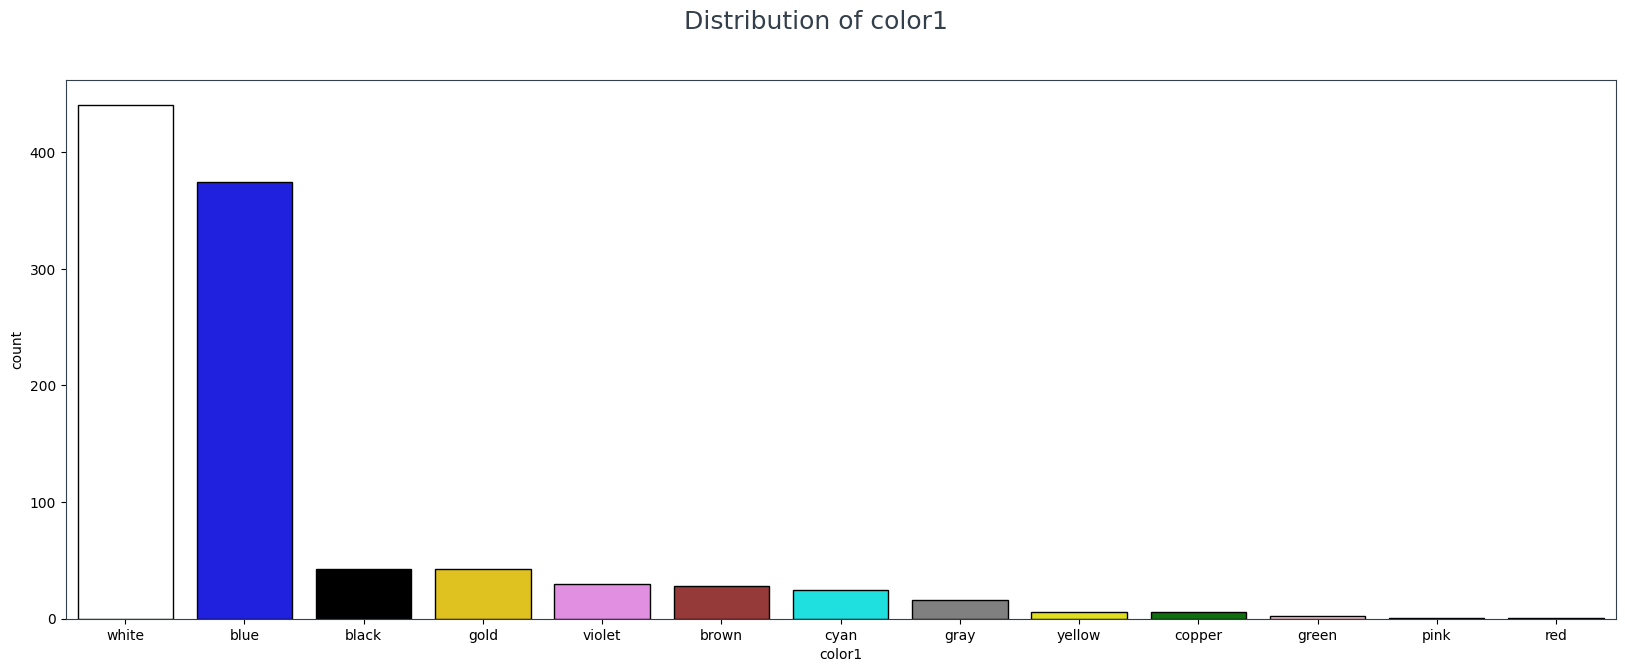

In [110]:
plt.rcParams['figure.figsize'] = (20, 7)
g = sns.countplot(data=color_df,
              x='color1',
              edgecolor='black',
              order=color_df['color1'].value_counts().index,
              palette=['white', 'blue', 'black', 'gold', 'violet', 'brown', 'cyan', 'gray', 'yellow', 'green', 'pink', 'red']);
plt.suptitle('Distribution of color1', fontsize=18, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;"> Ở lựa chọn màu thứ nhất thì đa phần mọi người lựa chọn giữa 2 màu trắng và xanh dương</span>

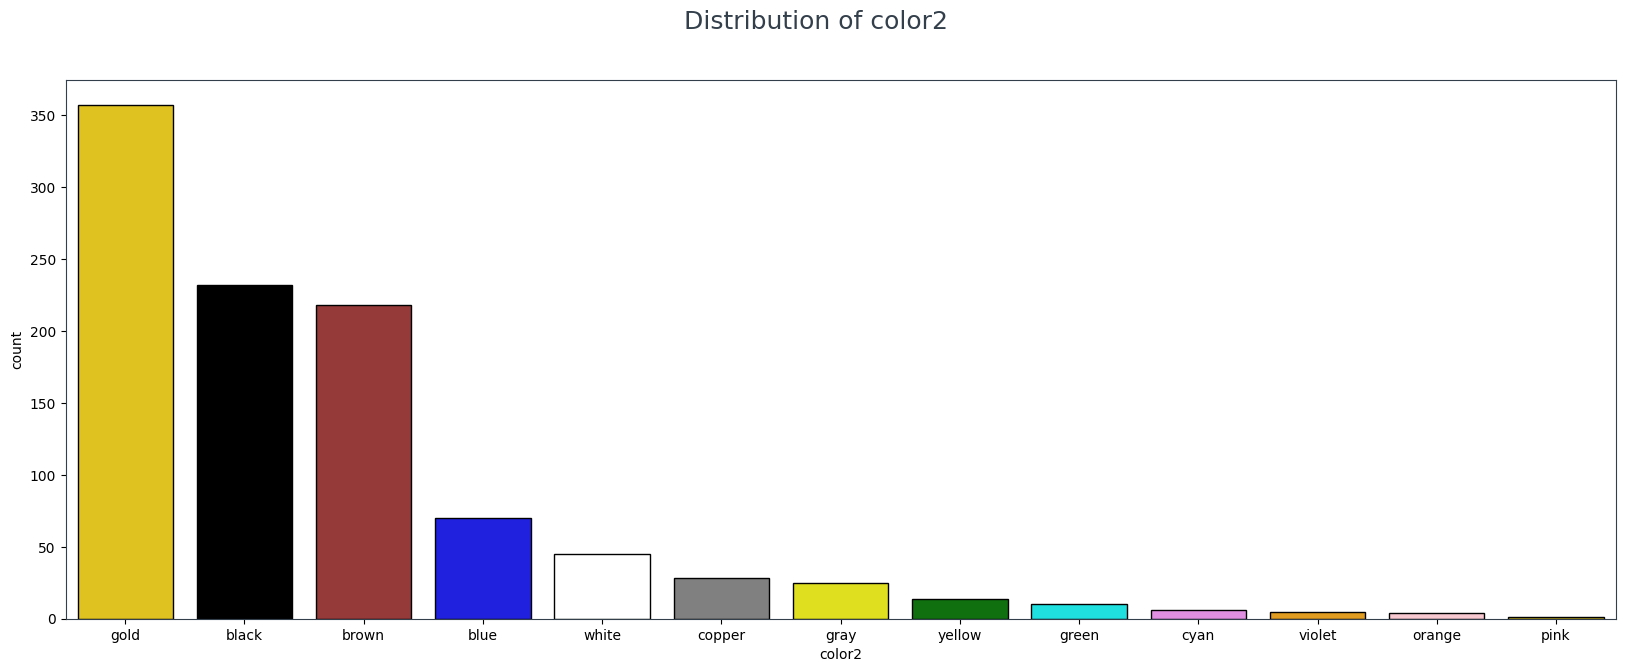

In [111]:
plt.rcParams['figure.figsize'] = (20, 7)
sns.countplot(data=color_df,
              x='color2',
              edgecolor='black',
              order=color_df['color2'].value_counts().index,
              palette=['gold', 'black', 'brown', 'blue', 'white', 'gray', 'yellow','green', 'cyan', 'violet', 'orange', 'pink']);
plt.suptitle('Distribution of color2', fontsize=18, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;"> Ở lựa chọn màu thứ hai thì màu sắc mọi người nhìn thấy đa đa dạng hơn, không chỉ màu vàng mà còn là màu đen, nâu và xanh trời.</span>

<span style="font-size:17px;font-family: Times New Roman;">Tiếp đến xem tỉ lệ phân bố dữ liệu `what group?` và `you` như thế nào?</span>

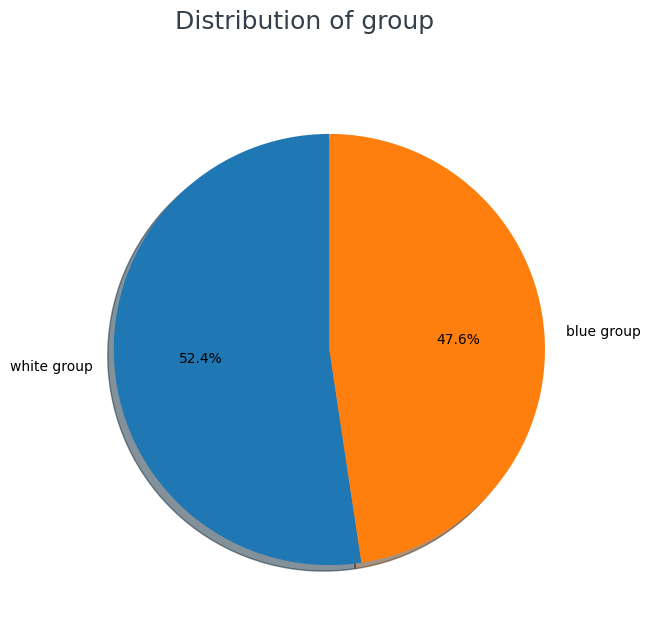

In [112]:
plt.pie(color_df['what group?'].value_counts(),
        labels=color_df['what group?'].value_counts().index,
        autopct='%1.1f%%',
        shadow=True,
        startangle=90);
plt.suptitle('Distribution of group', fontsize=18, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;"> Số lượng người cho từng group khá đều nhau, có nghĩa vấn đề nhìn ra màu sắc khác nhau này không phải là do nhóm thiểu số của một cộng đồng</span>

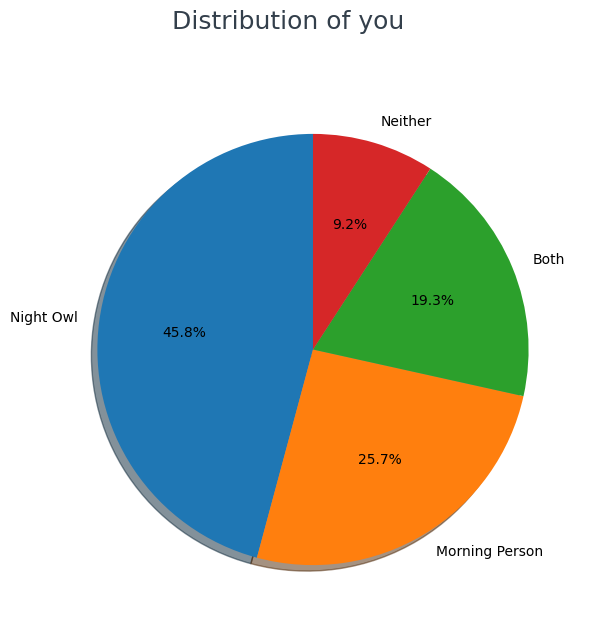

In [113]:
plt.pie(color_df['you'].value_counts(),
        labels=color_df['you'].value_counts().index,
        autopct='%1.1f%%',
        shadow=True,
        startangle=90);
plt.suptitle('Distribution of you', fontsize=18, color = '#333F4B');

### 3.8. Phân tích mối quan hệ giữa các biến


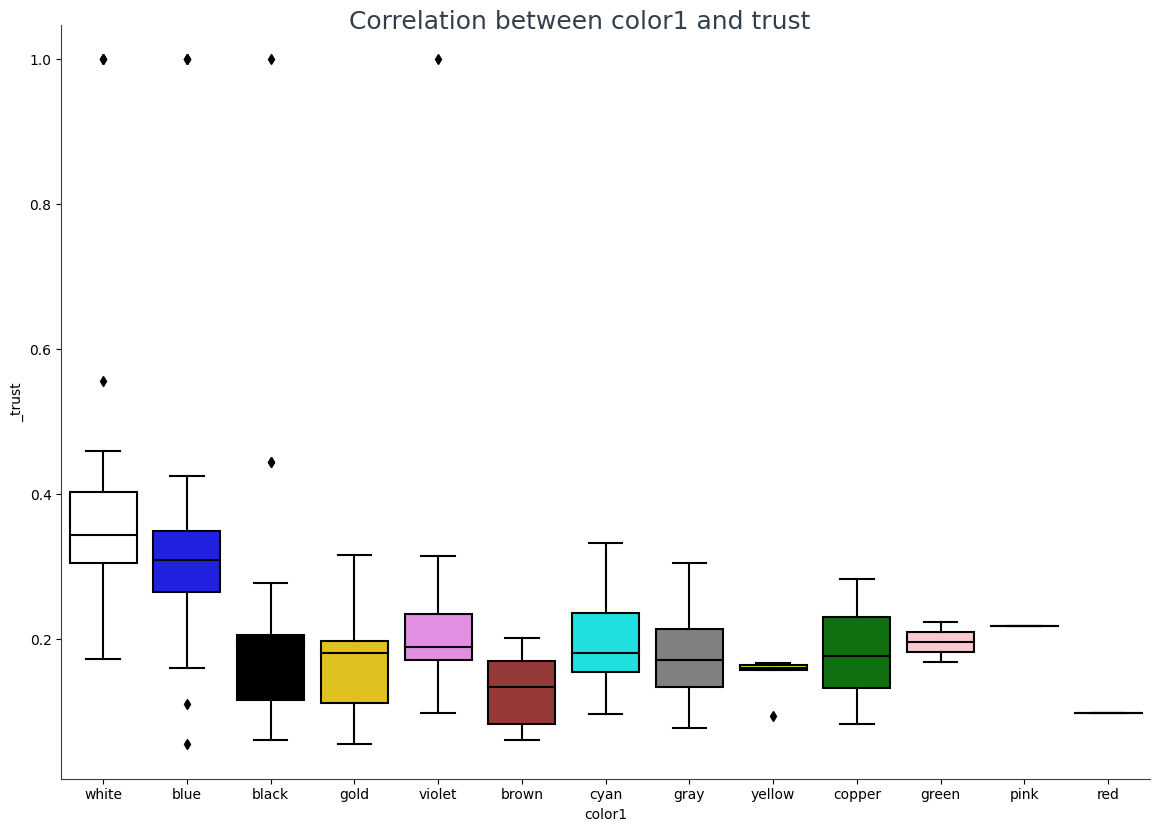

In [115]:
sns.catplot(data=color_df,
            x='color1',
            y='_trust',
            kind='box',
            order=color_df['color1'].value_counts().index,
            palette=['white', 'blue', 'black', 'gold', 'violet', 'brown', 'cyan', 'gray', 'yellow', 'green', 'pink', 'red'],
            height=8.27, aspect=11.7/8.27);
plt.suptitle('Correlation between color1 and trust', y=1, fontsize=18, color = '#333F4B');

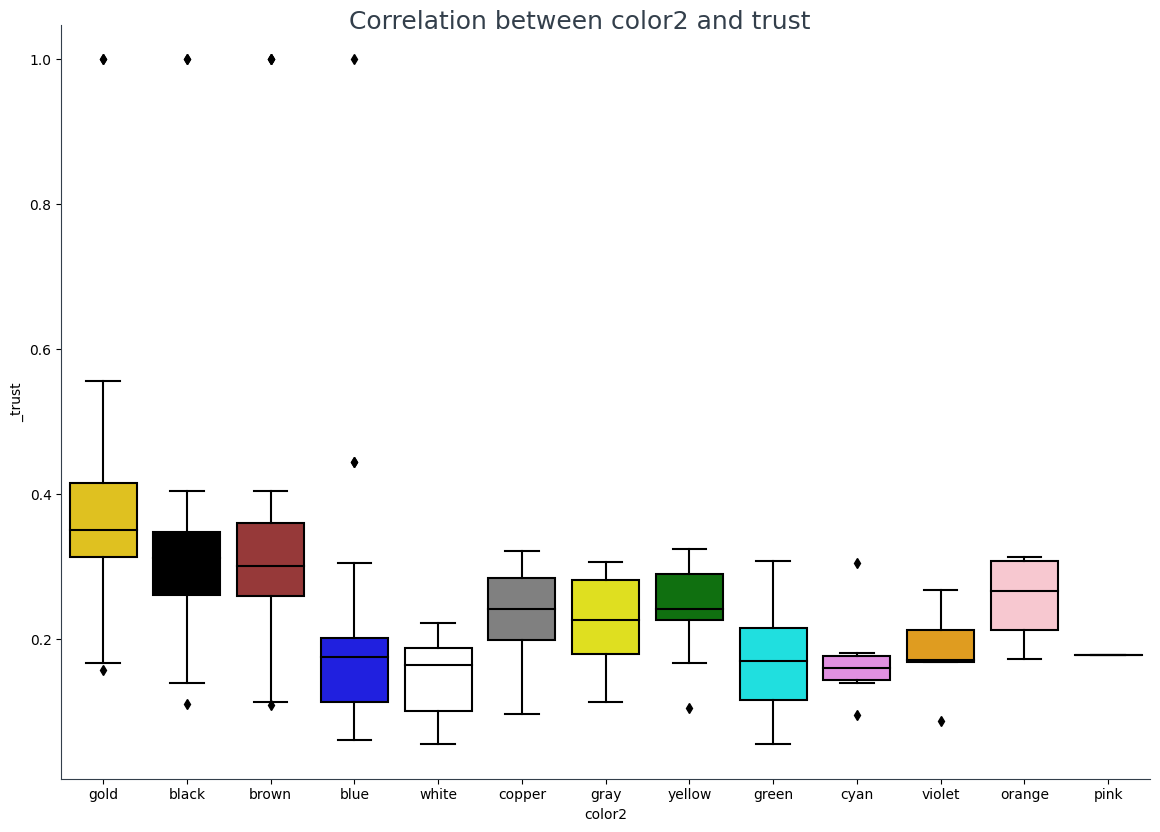

In [116]:
sns.catplot(data=color_df,
            x='color2',
            y='_trust',
            kind='box',
            order=color_df['color2'].value_counts().index,
            palette=['gold', 'black', 'brown', 'blue', 'white', 'gray', 'yellow','green', 'cyan', 'violet', 'orange', 'pink'],
            height=8.27, aspect=11.7/8.27);
plt.suptitle('Correlation between color2 and trust', y=1, fontsize=18, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;"> Qua 2 biểu đồ trên thì ta thấy rằng với các màu được chọn nhiều nhất thì độ tin tưởng của người bình chọn cũng sẽ cao hơn các màu còn lại. Có thể do hiệu ứng đám đông nên các màu được chọn nhiều khiến người bình chọn tự tin hơn với lựa chọn của mình. Ta cũng thấy outlier với tự tin cao nhất (1.0) xuất hiện ở các màu này</span>

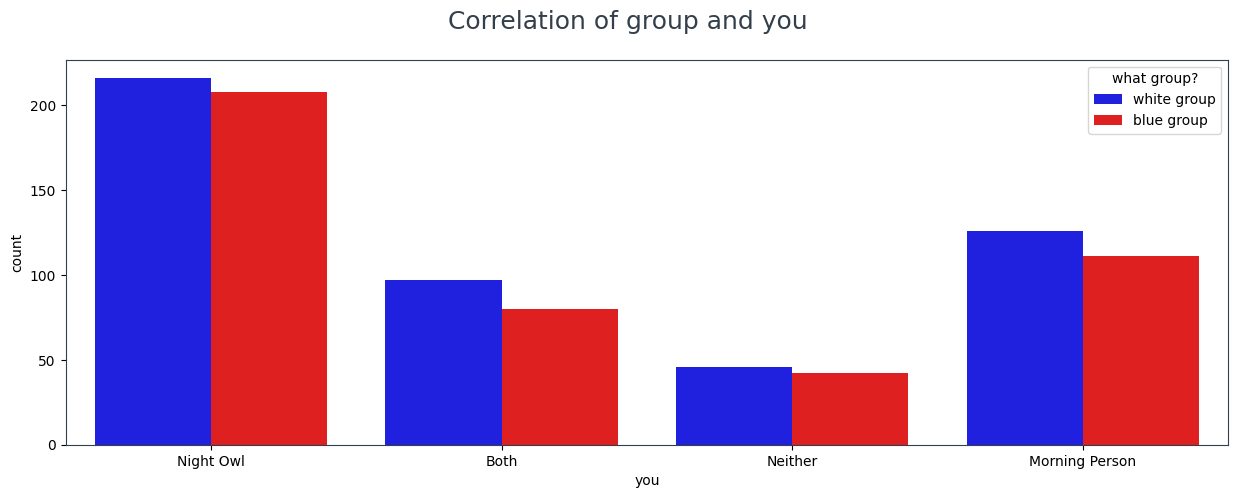

In [117]:
plt.rcParams['figure.figsize'] = 15, 5
sns.countplot(data=color_df,
              x='you',
              hue='what group?',
              palette=['blue', 'red']);
plt.suptitle('Correlation of group and you', fontsize=18, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;"> Khi tiếp cận vấn đề  của dataset này, nhiều người sẽ đặt câu hỏi tại sao mỗi người lại nhìn ra một màu khác nhau. Thì người thu thập dữ liệu này cũng có đề cấp đến việc có phải do giờ ngủ khác nhau khiến mỗi người nhìn ra một màu khác nhau hay không? Thì biểu đồ này cho ta thấy với mỗi loại người khác nhau, tỉ lệ nhìn thấy màu khác nhau là như nhau.</span>